In [11]:
import pandas as pd
from matplotlib import pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.svm import SVC, LinearSVC
from sklearn.preprocessing import RobustScaler
from sklearn.ensemble import RandomForestClassifier
import seaborn as sns

In [2]:
df = pd.read_csv("../data/match_data_compact.csv")

scaler = RobustScaler().set_output(transform="pandas")
X = df.drop(columns=["blueTeamWin"])
X = scaler.fit_transform(X)
y = df["blueTeamWin"]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, random_state=42)

In [13]:
dt = RandomForestClassifier()

param_grid = {
    'n_estimators':[10,100,500],
    'max_depth':[7,20,100], 
}

grid = GridSearchCV(
    estimator=dt,
    param_grid=param_grid,
    n_jobs=-1,
    cv = 5,
    scoring = 'accuracy'
)
grid.fit(X_train,y_train)

best_dt = grid.best_estimator_
print("Mejores parámetros:", grid.best_params_)
print("Mejor puntuación de validación cruzada:", grid.best_score_)


Mejores parámetros: {'max_depth': 7, 'n_estimators': 500}
Mejor puntuación de validación cruzada: 0.7649002064693737


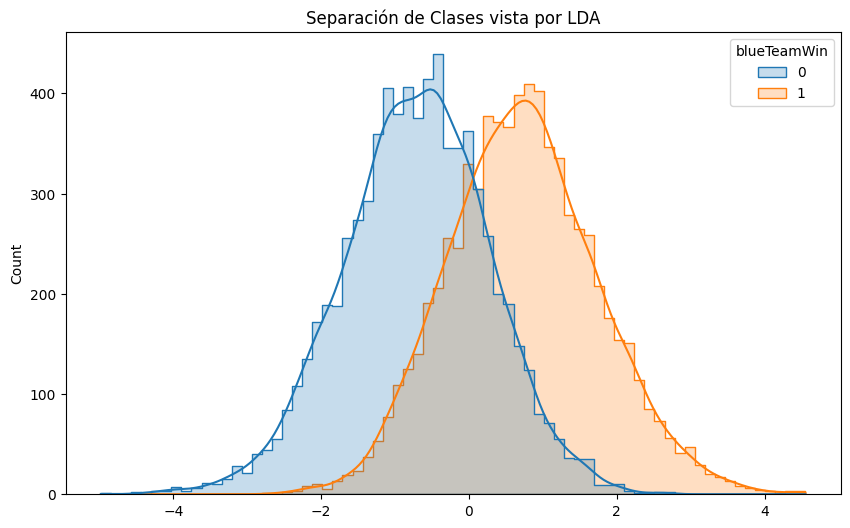

In [5]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis


lda = LinearDiscriminantAnalysis(n_components=1) 
X_lda = lda.fit_transform(X_train, y_train)




plt.figure(figsize=(10, 6))
sns.histplot(x=X_lda.flatten(), hue=y_train, kde=True, element="step")
plt.title("Separación de Clases vista por LDA")
plt.show()

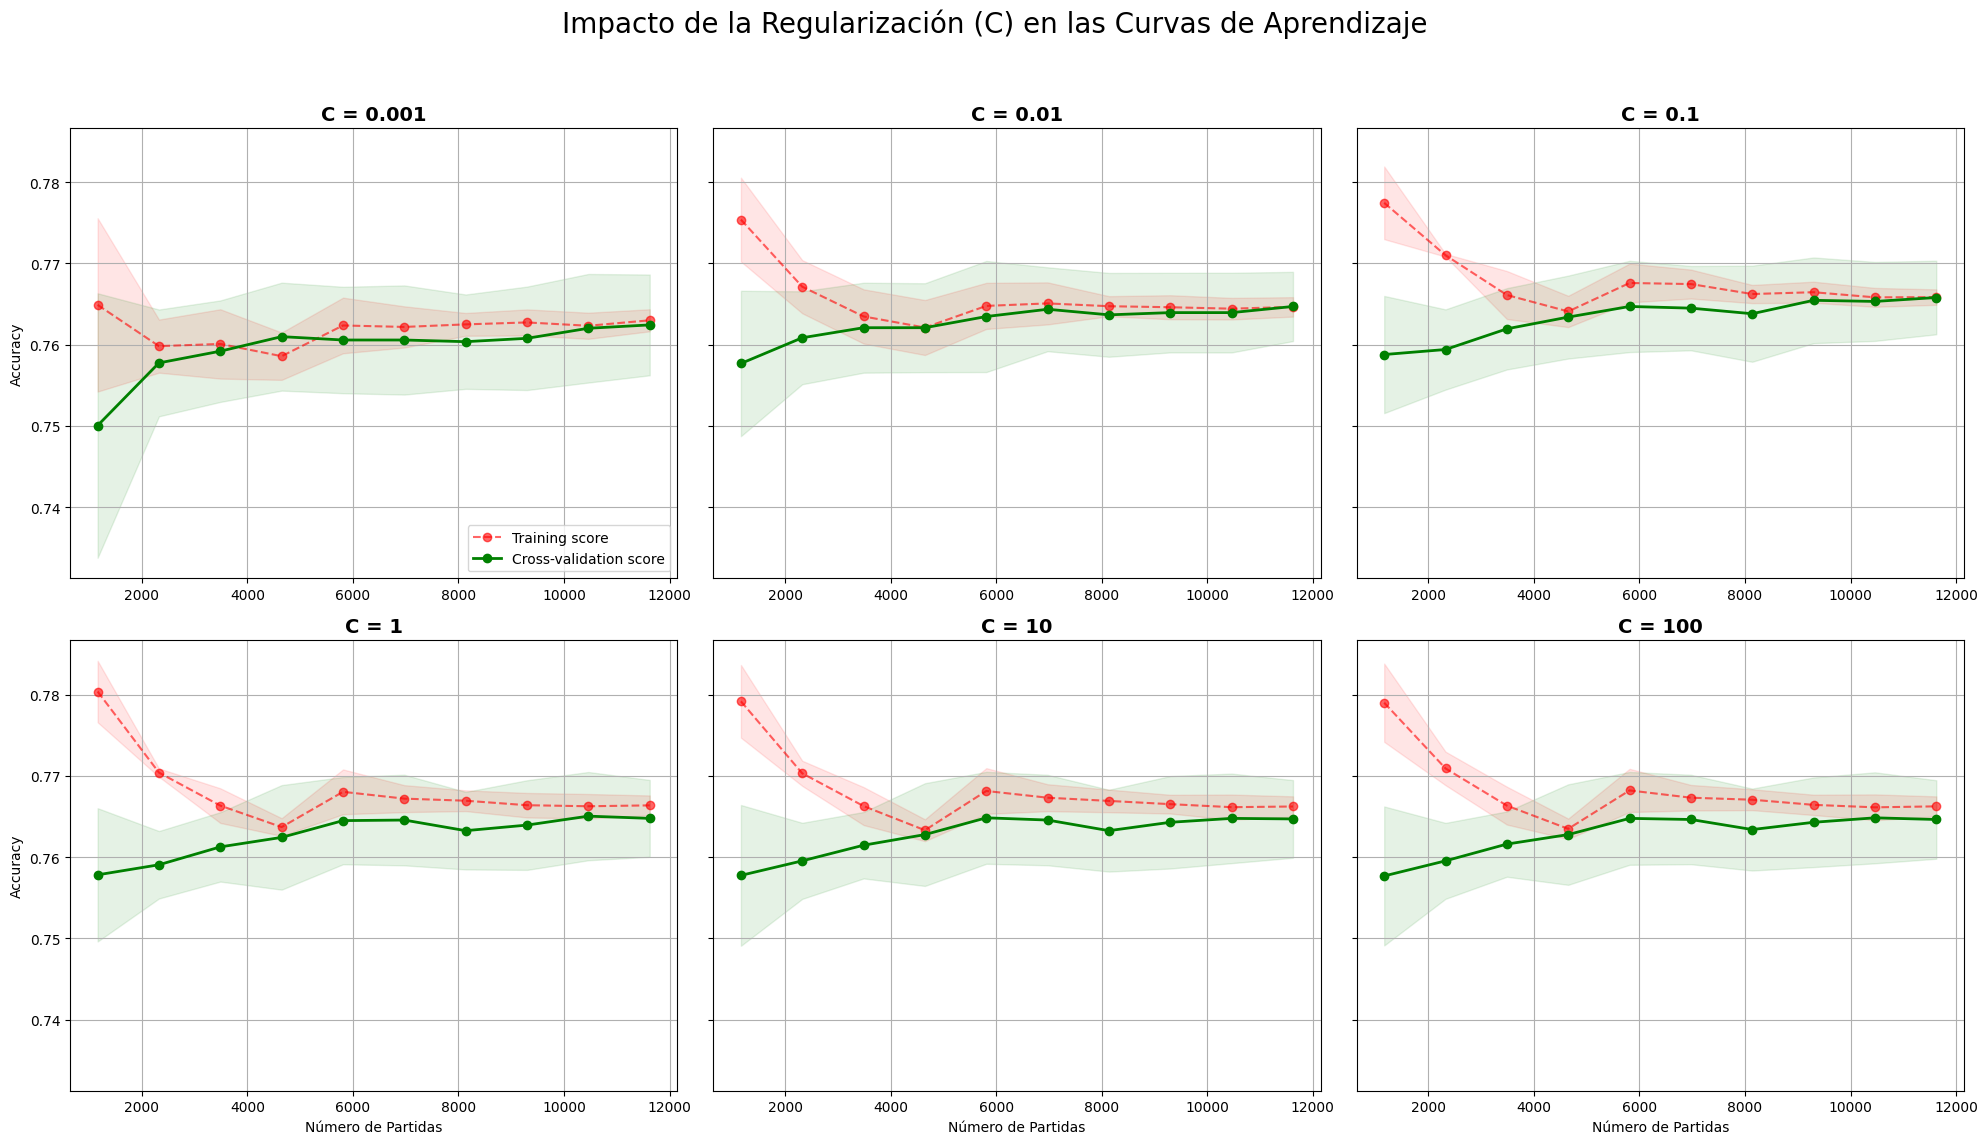

In [19]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import learning_curve
from sklearn.linear_model import LogisticRegression

# 1. Valores de C a probar (De muy restringido a muy libre)
c_values = [0.001, 0.01, 0.1, 1, 10, 100]

# 2. Configuración del panel de gráficos (2 filas x 3 columnas)
fig, axes = plt.subplots(2, 3, figsize=(20, 12), sharey=True)
axes = axes.flatten() # Aplanamos para poder iterar fácilmente

# Título general
fig.suptitle('Impacto de la Regularización (C) en las Curvas de Aprendizaje', fontsize=20)

# 3. Bucle para generar cada gráfico
for i, c in enumerate(c_values):
    ax = axes[i]
    
    # Creamos el modelo
    model = LogisticRegression(C=c, max_iter=2000, solver='lbfgs')
    
    # Calculamos curvas
    train_sizes, train_scores, test_scores = learning_curve(
        estimator=model,
        X=X_train, 
        y=y_train,
        cv=5,
        n_jobs=-1,
        train_sizes=np.linspace(0.1, 1.0, 10),
        scoring='accuracy'
    )
    
    # Medias y Desviaciones
    train_mean = np.mean(train_scores, axis=1)
    train_std = np.std(train_scores, axis=1)
    test_mean = np.mean(test_scores, axis=1)
    test_std = np.std(test_scores, axis=1)
    
    # --- PINTAR TRAIN (Rojo) ---
    ax.plot(train_sizes, train_mean, 'o--', color="r", label="Training score", alpha=0.6)
    ax.fill_between(train_sizes, train_mean - train_std, train_mean + train_std, alpha=0.1, color="r")
    
    # --- PINTAR TEST (Verde) ---
    ax.plot(train_sizes, test_mean, 'o-', color="g", label="Cross-validation score", linewidth=2)
    ax.fill_between(train_sizes, test_mean - test_std, test_mean + test_std, alpha=0.1, color="g")
    
    # Decoración de cada subgráfico
    ax.set_title(f"C = {c}", fontsize=14, fontweight='bold')
    ax.grid(True)
    
    # Solo ponemos etiquetas en los bordes para no ensuciar
    if i >= 3: # Solo en la fila de abajo
        ax.set_xlabel("Número de Partidas")
    if i % 3 == 0: # Solo en la columna izquierda
        ax.set_ylabel("Accuracy")
        
    # Leyenda solo en el primer gráfico para no repetir
    if i == 0:
        ax.legend(loc="lower right")

plt.tight_layout(rect=[0, 0.03, 1, 0.95]) # Ajustar para que no choque con el título
plt.show()

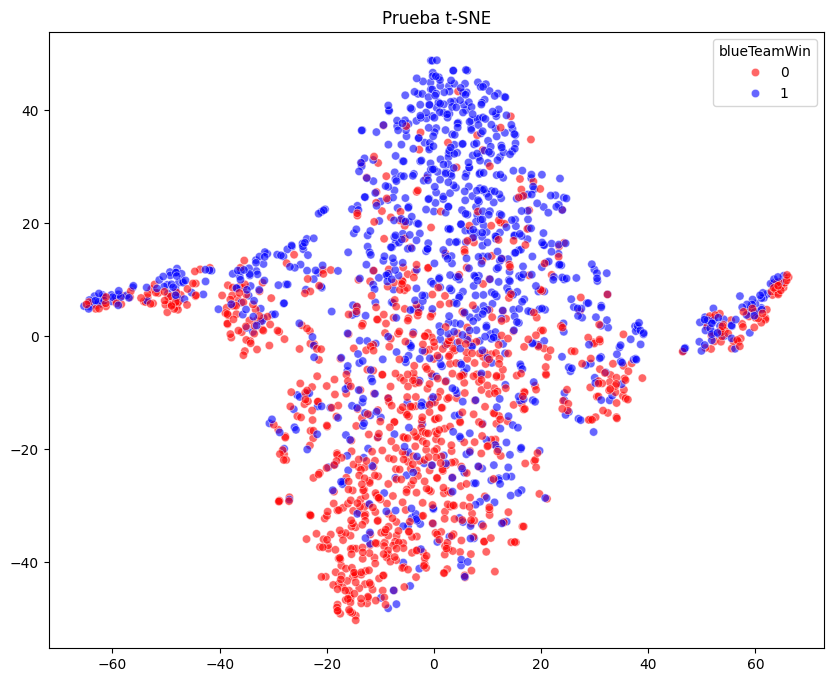

In [9]:
from sklearn.neighbors import KNeighborsClassifier
import numpy as np

knn = KNeighborsClassifier(n_neighbors=5)
knn.fit(X_train, y_train)

neighbors = knn.kneighbors(X_test, return_distance=False)
y_test_array = y_test.to_numpy() 


confused_points = 0
for i, neighbor_indices in enumerate(neighbors):
    true_label = y_test_array[i]
    neighbor_labels = y_train.iloc[neighbor_indices].values
    prediction = 1 if np.mean(neighbor_labels) > 0.5 else 0
    if prediction != true_label:
        confused_points += 1

print(f"Porcentaje de partidas que son geométricamente indistinguibles de su contrario: {confused_points / len(X_test) * 100:.2f}%")

Porcentaje de partidas que son geométricamente indistinguibles de su contrario: 29.18%
